In [1]:
# taken from:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

import os
import pandas as pd
import numpy as np
from skimage import io, transform
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

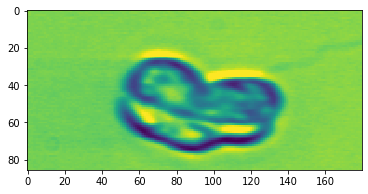

In [38]:
## helper functions

data_folder = "./data"

# get all labels and file names
def get_lbls_fnames(years, ignored_classes=[]):
    fnames = []
    labels = []
    for year in years:
        year_path = data_folder+"/"+year
        if os.path.isdir(year_path):
            for class_name in os.listdir(year_path):
                if class_name in ignored_classes:
                    continue
                c_path = year_path + "/"+class_name

                if os.path.isdir(c_path):
                    image_files = [x for x in os.listdir(c_path) if ".png" in x]
                    fnames.extend(image_files)
                    labels.extend([class_name]*len(image_files))
    return fnames, labels

# image transformations
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image':img, 'label':sample['label']}

# for data augmentation
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h) 
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image':image, 'label':sample['label']}

# to convert numpy images to torch images
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((0, 1))
        return {'image':torch.from_numpy(image), 'label':sample['label']}

# to show image
def show_plankton(image, size):
    plt.imshow(image.reshape(size))
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()

img_names = np.array(os.listdir('data/2006/Karenia'))
img = io.imread(os.path.join('data/2006/Karenia', img_names[0]))
show_plankton(img, img.shape)
plt.show()

In [43]:
#dataset class
class PlanktonDataset(Dataset):
    
    def __init__(self, ids, labels, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_ids = ids
        self.file_labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_ids)
    
    def __getitem__(self, index):
        file_name = self.file_ids[index]
        year = file_name.split("_")[1]
        label = self.file_labels[index] 
        
        img_name = os.path.join(self.root_dir, year, label, file_name)
        img = io.imread(img_name)


        sample = {'image': img, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        
        sample['image'] = sample['image'].reshape((1,sample['image'].shape[0], sample['image'].shape[1]))
        return sample

0 torch.Size([1, 120, 255]) mix


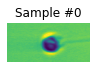

1 torch.Size([1, 120, 255]) mix


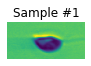

2 torch.Size([1, 120, 255]) mix


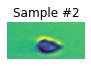

3 torch.Size([1, 120, 255]) mix


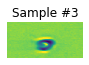

In [44]:
years = [str(i) for i in range(2006, 2007)]
fnames, lbls = get_lbls_fnames(years)

dataset = PlanktonDataset(fnames, lbls, './data', transform=transforms.Compose([
                                               Rescale((120, 255)),
                                               ToTensor()
                                           ]))

fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]

    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_plankton(sample['image'], (sample['image'].shape[1], sample['image'].shape[2]))

    if i == 3:
        plt.show()
        break
        
        

In [ ]:
# examples for Transformations
"""
scale = Rescale(256)
crop = RandomCrop(20)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(200)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_plankton(transformed_sample['image'])

plt.show()


# using torchvision to 
from torchvision import datasets, transforms
data_transform = transforms.Compose([
        transforms.Resize(255),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
"""

0 torch.Size([4, 1, 120, 255])
1 torch.Size([4, 1, 120, 255])
2 torch.Size([4, 1, 120, 255])
3 torch.Size([4, 1, 120, 255])


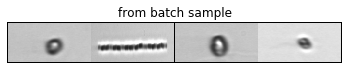

In [45]:
# using DataLoader
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=4)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch = sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size()
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title("from batch sample")

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [49]:
# so we have the dataset, now the CNN LOL. taken from: simple_CNN
#Define a CNN

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

#define the loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [50]:
for x in net.parameters():
    print(x.size())

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [ ]:
#train the network
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get the unputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #zero the param gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i+1, running_loss/2000))
            running_loss = 0.0
            
print('Finished Training')
